# Convolutional Neural Networks

In this notebook, I'll try converting radio images into useful features using a simple convolutional neural network in Keras. The best kinds of CNN to use are apparently fast region-based CNNs, but because computer vision is hard and somewhat off-topic I'll instead be doing this pretty naïvely. The [Keras MNIST example](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py) will be a good starting point.

I'll also use SWIRE to find potential hosts (notebook 13) and pull out radio images surrounding them. I'll be using the frozen ATLAS classifications that I prepared earlier (notebook 12).

In [1]:
import collections
import io
from pprint import pprint
import sqlite3
import sys
import warnings

import astropy.io.votable
import astropy.wcs
import matplotlib.pyplot
import numpy
import requests
import requests_cache
import sklearn.cross_validation

%matplotlib inline

sys.path.insert(1, '..')
import crowdastro.data
import crowdastro.labels
import crowdastro.rgz_analysis.consensus
import crowdastro.show

warnings.simplefilter('ignore', UserWarning)  # astropy always raises warnings on Windows.

requests_cache.install_cache(cache_name='gator_cache', backend='sqlite', expire_after=None)

In [2]:
def get_potential_hosts(subject):
    if subject['metadata']['source'].startswith('C'):
        # CDFS
        catalog = 'chandra_cat_f05'
    else:
        # ELAIS-S1
        catalog = 'elaiss1_cat_f05'
    
    query = {
        'catalog': catalog,
        'spatial': 'box',
        'objstr': '{} {}'.format(*subject['coords']),
        'size': '120',
        'outfmt': '3',
    }
    url = 'http://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-query'

    r = requests.get(url, params=query)
    votable = astropy.io.votable.parse_single_table(io.BytesIO(r.content), pedantic=False)
    
    ras = votable.array['ra']
    decs = votable.array['dec']

    # Convert to px.
    fits = crowdastro.data.get_ir_fits(subject)
    wcs = astropy.wcs.WCS(fits.header)
    xs, ys = wcs.all_world2pix(ras, decs, 0)
    
    return numpy.array((xs, ys)).T

def get_true_hosts(subject, potential_hosts, conn):
    consensus_xs = []
    consensus_ys = []
    consensus = crowdastro.labels.get_subject_consensus(subject, conn, 'atlas_classifications')
    
    true_hosts = {}  # Maps radio signature to (x, y) tuples.
    for radio, (x, y) in consensus.items():
        if x is not None and y is not None:
            closest = None
            min_distance = float('inf')

            for host in potential_hosts:
                dist = numpy.hypot(x - host[0], y - host[1])
                if dist < min_distance:
                    closest = host
                    min_distance = dist

            true_hosts[radio] = closest
    
    return true_hosts        

## Training data

The first step is to separate out all the training data. I'm well aware that having too much training data at once will cause Python to run out of memory, so I'll need to figure out how to deal with that when I get to it.

For each potential host, I'll pull out a $20 \times 20$, $40 \times 40$, and $80 \times 80$ patch of radio image. These numbers are totally arbitrary but they seem like nice sizes. Note that this will miss really spread out black hole jets. I'm probably fine with that.

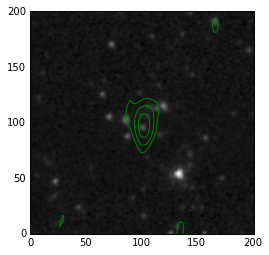

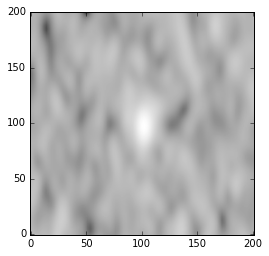

In [3]:
subject = crowdastro.data.db.radio_subjects.find_one({'zooniverse_id': 'ARG0003rga'})
crowdastro.show.subject(subject)
matplotlib.pyplot.show()
crowdastro.show.radio(subject)
matplotlib.pyplot.show()

In [4]:
potential_hosts = get_potential_hosts(subject)

In [5]:
conn = sqlite3.connect('../crowdastro-data/processed.db')
true_hosts = {tuple(i) for i in get_true_hosts(subject, potential_hosts, conn).values()}

conn.close()

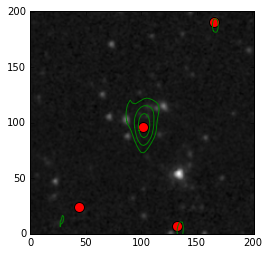

In [6]:
xs = []
ys = []
for x, y in true_hosts:
    xs.append(x)
    ys.append(y)

crowdastro.show.subject(subject)
matplotlib.pyplot.scatter(xs, ys, c='r', s=100)
matplotlib.pyplot.show()

In [7]:
def get_training_data(subject, potential_hosts, true_hosts):
    radio_image = crowdastro.data.get_radio(subject, size='5x5')
    
    training_data = []
    radius = 40
    padding = 150
    for host_x, host_y in potential_hosts:
        patch_80 = radio_image[int(host_x - radius + padding) : int(host_x + radius + padding),
                               int(host_y - radius + padding) : int(host_y + radius + padding)]
        classification = (host_x, host_y) in true_hosts
        training_data.append((patch_80, classification))
    
    return training_data

In [8]:
patches, classifications = zip(*get_training_data(subject, potential_hosts, true_hosts))

Now, I'll run this over the ATLAS data.

In [11]:
conn = sqlite3.connect('../crowdastro-data/processed.db')
training_inputs = []
training_outputs = []
for index, subject in enumerate(crowdastro.data.get_all_subjects(atlas=True)):
    print('Extracting training data from ATLAS subject #{}'.format(index))
    potential_hosts = get_potential_hosts(subject)
    true_hosts = {tuple(i) for i in get_true_hosts(subject, potential_hosts, conn).values()}
    patches, classifications = zip(*get_training_data(subject, potential_hosts, true_hosts))
    training_inputs.extend(patches)
    training_outputs.extend(classifications)
conn.close()

Extracting training data from ATLAS subject #0
Extracting training data from ATLAS subject #1
Extracting training data from ATLAS subject #2
Extracting training data from ATLAS subject #3
Extracting training data from ATLAS subject #4
Extracting training data from ATLAS subject #5
Extracting training data from ATLAS subject #6
Extracting training data from ATLAS subject #7
Extracting training data from ATLAS subject #8
Extracting training data from ATLAS subject #9
Extracting training data from ATLAS subject #10
Extracting training data from ATLAS subject #11
Extracting training data from ATLAS subject #12
Extracting training data from ATLAS subject #13
Extracting training data from ATLAS subject #14
Extracting training data from ATLAS subject #15
Extracting training data from ATLAS subject #16
Extracting training data from ATLAS subject #17
Extracting training data from ATLAS subject #18
Extracting training data from ATLAS subject #19
Extracting training data from ATLAS subject #20
Ex

Keras doesn't support class weights, so I need to downsample the non-host galaxies.

In [12]:
n_hosts = sum(training_outputs)
n_not_hosts = len(training_outputs) - n_hosts
n_to_discard = n_not_hosts - n_hosts

new_training_inputs = []
new_training_outputs = []

for inp, out in zip(training_inputs, training_outputs):
    if not out and n_to_discard > 0:
        n_to_discard -= 1
    else:
        new_training_inputs.append(inp)
        new_training_outputs.append(out)

print(sum(new_training_outputs))
print(len(new_training_outputs))

7634
15268


In [13]:
training_inputs = numpy.array(new_training_inputs)
training_outputs = numpy.array(new_training_outputs, dtype=float)

## Convolutional neural network

The basic structure will be as follows:

- An input layer.
- A 2D convolution layer with 32 filters and a $10 \times 10$ kernel. (This is the same size kernel that Radio Galaxy Zoo uses for their peak detection.)
- A relu activation layer.
- A max pooling layer with pool size 5.
- A 25% dropout layer.
- A flatten layer.
- A dense layer with 64 nodes.
- A relu activation layer.
- A dense layer with 1 node.
- A sigmoid activation layer.

I may try to split the input into three images of different sizes in future.

In [14]:
import keras.layers.convolutional
import keras.layers.core
import keras.models

Using Theano backend.


In [16]:
model = keras.models.Sequential()

n_filters = 32
conv_size = 10
pool_size = 5
dropout = 0.25
hidden_layer_size = 64

model.add(keras.layers.convolutional.Convolution2D(n_filters, conv_size, conv_size,
                                                   border_mode='valid',
                                                   input_shape=(1, 80, 80)))
model.add(keras.layers.core.Activation('relu'))
model.add(keras.layers.convolutional.MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(keras.layers.core.Dropout(dropout))
model.add(keras.layers.core.Flatten())
model.add(keras.layers.core.Dense(hidden_layer_size))
model.add(keras.layers.core.Activation('sigmoid'))
model.add(keras.layers.core.Dense(1))
model.add(keras.layers.core.Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adadelta')

Now we can train it!

In [17]:
xs_train, xs_test, ts_train, ts_test = sklearn.cross_validation.train_test_split(
        training_inputs, training_outputs, test_size=0.1, random_state=0, stratify=training_outputs)

image_size = xs_train.shape[1:]
xs_train = xs_train.reshape(xs_train.shape[0], 1, image_size[0], image_size[1])
xs_test = xs_test.reshape(xs_test.shape[0], 1, image_size[0], image_size[1])

In [18]:
xs_train.shape

(13740, 1, 80, 80)

In [19]:
model.fit(xs_train, ts_train)

Epoch 1/100
13740/13740 [==============================] - 248s - loss: 0.6069   
Epoch 2/100
13740/13740 [==============================] - 245s - loss: 0.5897   
Epoch 3/100
13740/13740 [==============================] - 250s - loss: 0.5864   
Epoch 4/100
13740/13740 [==============================] - 253s - loss: 0.5858   
Epoch 5/100
13740/13740 [==============================] - 252s - loss: 0.5835   
Epoch 6/100
13740/13740 [==============================] - 242s - loss: 0.5799   
Epoch 7/100
13740/13740 [==============================] - 241s - loss: 0.5791   
Epoch 8/100
13740/13740 [==============================] - 242s - loss: 0.5782   
Epoch 9/100
13740/13740 [==============================] - 242s - loss: 0.5790   
Epoch 10/100
13740/13740 [==============================] - 243s - loss: 0.5773   
Epoch 11/100
13740/13740 [==============================] - 241s - loss: 0.5779   
Epoch 12/100
13740/13740 [==============================] - 242s - loss: 0.5775   
Epoch 13/100


KeyboardInterrupt: 

Let's see some filters.

In [20]:
get_convolutional_output = keras.backend.function([model.layers[0].input],
                                                  [model.layers[2].get_output()])

In [32]:
model.get_weights()[0].shape

(32, 1, 10, 10)

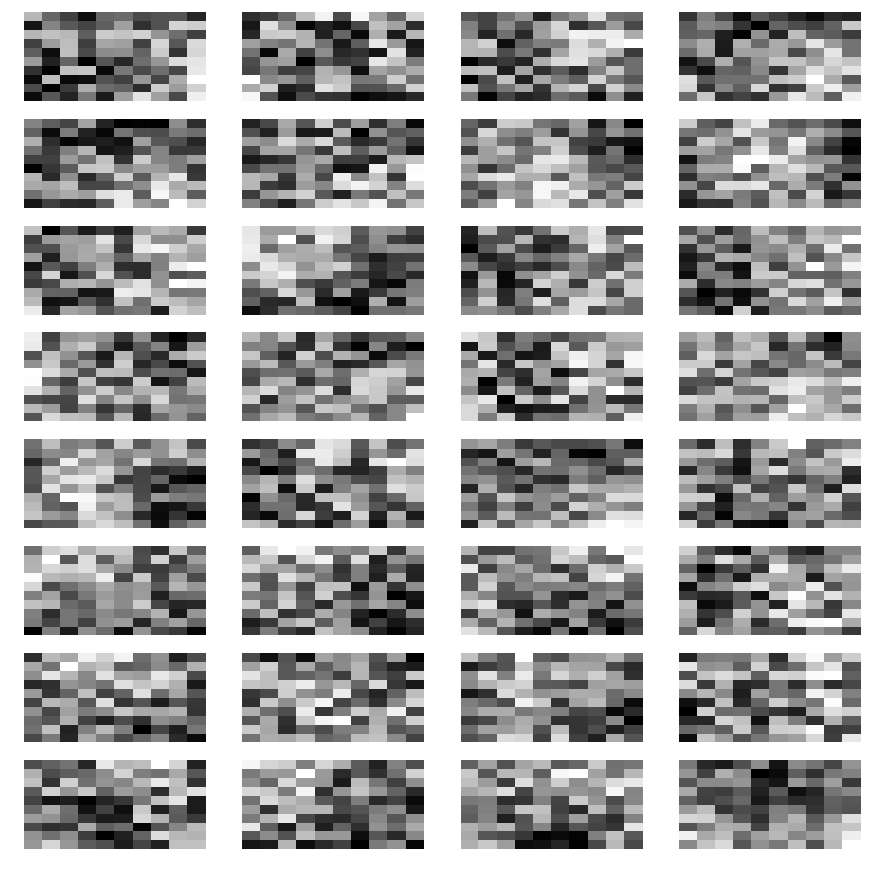

In [51]:
figure = matplotlib.pyplot.figure(figsize=(15, 15))

for i in range(32):
    ax = figure.add_subplot(8, 4, i+1)
    ax.axis('off')
    ax.pcolor(model.get_weights()[0][i, 0], cmap='gray')

matplotlib.pyplot.show()

Good enough. Now, let's save the models.

In [34]:
model_json = model.to_json()
with open('../crowdastro-data/cnn_model.json', 'w') as f:
    f.write(model_json)

model.save_weights('../crowdastro-data/cnn_weights.h5')

...Now, let's *test* that it saved.

In [53]:
with open('../crowdastro-data/cnn_model.json', 'r') as f:
    model2 = keras.models.model_from_json(f.read())

model2.load_weights('../crowdastro-data/cnn_weights.h5')

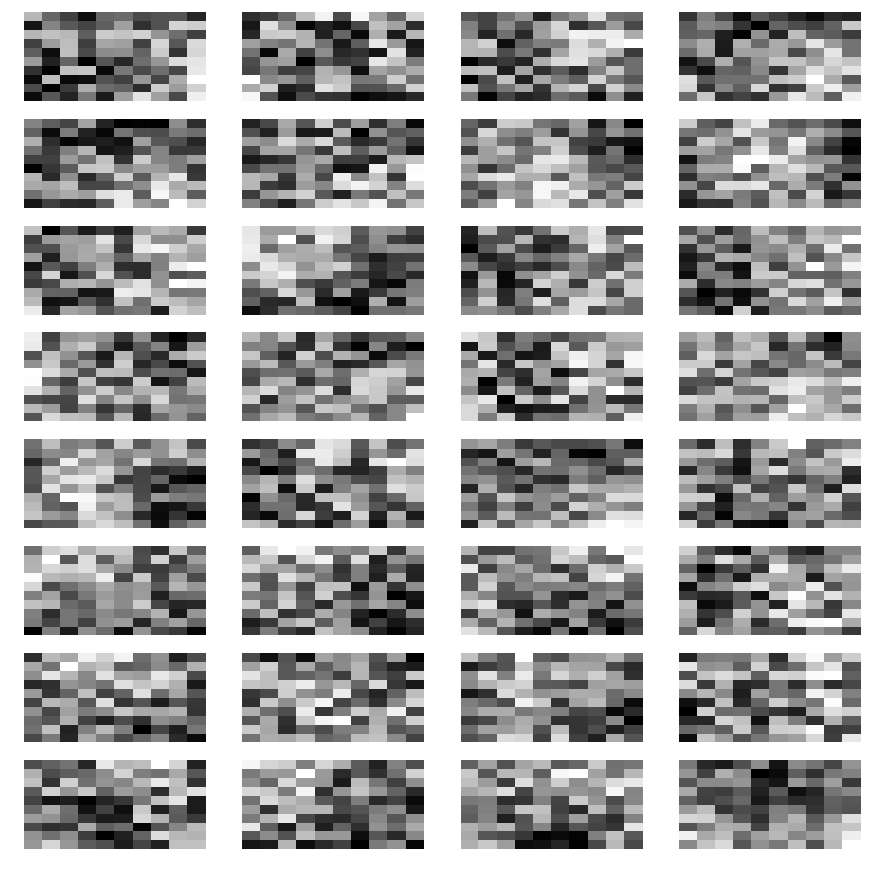

In [54]:
figure = matplotlib.pyplot.figure(figsize=(15, 15))

for i in range(32):
    ax = figure.add_subplot(8, 4, i+1)
    ax.axis('off')
    ax.pcolor(model2.get_weights()[0][i, 0], cmap='gray')

matplotlib.pyplot.show()

Looks good. Ideally, we train this longer, but I don't have enough time right now. Let's save the training data and move on.

In [57]:
import tables
with tables.openFile('../crowdastro-data/atlas_training_data.h5', mode='w', title='ATLAS training data') as f:
    root = f.root
    f.create_array(root, 'training_inputs', training_inputs)
    f.create_array(root, 'training_outputs', training_outputs)

K:\Languages\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: openFile() is pending deprecation, use open_file() instead. You may use the pt2to3 tool to update your source code.
  from ipykernel import kernelapp as app
